./output/2024-07-30 15:34/Error_Contingency_run_2024-07-30 15:34.txt
./output/2024-07-30 15:34
1 -- current it num
2 -- current it num
3 -- current it num
4 -- current it num
5 -- current it num
6 -- current it num
7 -- current it num
8 -- current it num
9 -- current it num
10 -- current it num
11 -- current it num
12 -- current it num
13 -- current it num
14 -- current it num
15 -- current it num

RESULTS

16 -- current it num
17 -- current it num
18 -- current it num
19 -- current it num
20 -- current it num
21 -- current it num
22 -- current it num
23 -- current it num
24 -- current it num
25 -- current it num
26 -- current it num
27 -- current it num
28 -- current it num
29 -- current it num
30 -- current it num


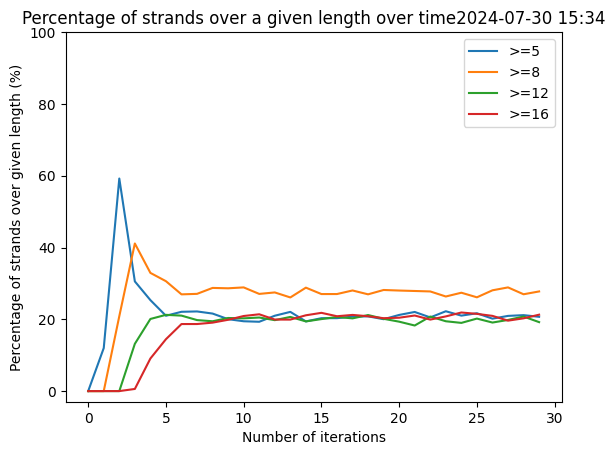

In [2]:
import numpy as np
from functions import *
import time
import seqfold
seed_value = 0
np.random.seed(seed_value)

#LAST UPDATE: 9/5/24 

#below are the variables we manipulate

init_nuc_num = 10000    # number of each base (10k A, 10k U, etc)
cleav_prop = 0.1   # chance of unstruc regions breaking during given run                  
cleav_prop_struct = 0.01   # chance of struc region breaking during given run
length_threshold = 10   # we wont check if something less than this long has struc
n_iterations = 30  # how many runs until completion
progress_report_freq  = 15   # how often code gives us a progress report / saves data to Error_Contingency file in case of error
dG_critical_value = -7.5

len1 = 5
len2 = 8    # these are the lengths we are using in the percent_over_certain_length functions
len3 = 12    #  see that function for more info
len4 = 16

list_of_percentage_nt_involved_in_structure = [] #used via percentage_nt_involved_in_structure function



#below are string versions of the variables used - this is written to our output file to help us track what settings produced the sequences
init_nuc_num_str = "*init_nuc_num = " + str(init_nuc_num) + "\n"
cleav_prop_str = "*cleav_prop = " + str(cleav_prop) + "\n"
cleav_prop_struct_str = "*cleav_prop_struct = " + str(cleav_prop_struct) + "\n"
length_threshold_str = "*length_threshold = " + str(length_threshold) + "\n"
n_iterations_str = "*n_iterations = " + str(n_iterations) + "\n"
progress_report_freq_str = "*progress_report_freq = " + str(progress_report_freq) + "\n"
seed_value_str = "*numpy random seed value = " + str(seed_value) + "\n"
dG_critical_value_str = "*dg critical value = " + str(dG_critical_value) + "\n"
settings_used = init_nuc_num_str + cleav_prop_str + cleav_prop_struct_str +  \
    length_threshold_str +  n_iterations_str + progress_report_freq_str + seed_value_str + \
     dG_critical_value_str + "\n"


#the below are used to create the file names
current_time_struct = time.localtime()
formatted_time = str(time.strftime("%Y-%m-%d %H:%M", current_time_struct))
base_directory = "./output/"
folder_name = formatted_time
blank_txt_file_paramater = "Error_Contingency" # see create_blank_text_file for description


file_path, output_directory = create_blank_text_file(base_directory, folder_name, blank_txt_file_paramater)
print(file_path)
print(output_directory)
file_to_write_to = open(file_path, "a")
file_to_write_to.write(settings_used)
final_file_path = None

list_of_percent_lens = []


###NOVEL 6/20/24
throwing_long_ones_out = False # this means we are throwing away all sequences that are longer than a set length to study the emergence of novel sequences
length_to_throw_out = 20

if throwing_long_ones_out == True:
    seqs_over_certain_length_filename = f"Sequences_over_{length_to_throw_out}_in_length.txt"
    seqs_over_certain_length_filepath = generate_final_seq_file(output_directory, seqs_over_certain_length_filename)
    with open(seqs_over_certain_length_filepath, "a") as seqs_over_certain_length_write:
        try:
            seqs_over_certain_length_write.write(settings_used)
            seqs_over_certain_length_write.flush()  # Ensure the data is flushed to the file
        except Exception as e:
            print(f"An error occurred while writing to the file: {e}")
###NOVEL 6/20/24





### BELOW BEGINS NUCLEIC COMPUTATIONS

# A general note: Here we use numpy array of dtype=object because Python
# can support arbitrarily large integers. In contrast, NumPy int64 type
# will overflow for long sequences
nucleotide_list = np.array([1, 2, 3, 4] * init_nuc_num, dtype=object)
# Mapping from integer numbers to nucleobase names
mapping = {"1": "A", "2": "G", "3": "C", "4": "U"}

# Initial Phase 1
# Shuffle the nucleobases, then pair them
# We represent a nucleic acid strand by a sequence of integers (e.g. 11 is AA)
# So multiply a number by 10 and to another number to create a dimer
np.random.shuffle(nucleotide_list)
size = nucleotide_list.size
nucleotide_list = nucleotide_list[:size//2] + 10 * nucleotide_list[size//2:]

# Initial Phase 3
# Randomly break dimer bonds to create a set of monomers and dimers
cleave = np.random.random(nucleotide_list.size) > cleav_prop
cleaved = nucleotide_list[cleave]
uncleaved = nucleotide_list[~cleave]

cleaved_1 = cleaved//10
cleaved_2 = cleaved%10

nucleotide_list = np.concatenate((uncleaved, cleaved_1, cleaved_2))


longest_strand_length_list = []
list_of_seqs_over_length_threshold = []

for it in range(1, n_iterations + 1):
    print(str(it) + " -- current it num")
    
    strand_length_tracking_list = []

    # Phase 1: Pair nucleotide strands
    # Shuffle list of nucleotide strands
    np.random.shuffle(nucleotide_list)

    # Take the first half of the strands and calculate their lengths
    size = nucleotide_list.size
    # Use dtype=object to keep arbitrary integer prevision
    order = order_of_mag(nucleotide_list[:size//2]).astype(object)

    # If we have an even number, pair all of them
    if size%2 == 0:
        nucleotide_list = nucleotide_list[:size//2] + 10**order * nucleotide_list[size//2:]

    # If we have an odd number, do not pair last strand
    else:
        nucleotide_list_temp = nucleotide_list[:size//2] + 10**order * nucleotide_list[size//2:-1]
        nucleotide_list = np.hstack((nucleotide_list_temp, nucleotide_list[-1]))

    # Phase 2: Determine folded structures and randomly break bonds in long strands
    order = order_of_mag(nucleotide_list).astype(object)
    mono = nucleotide_list[order == 1]
    short = nucleotide_list[np.logical_and(order > 1, order < length_threshold)]
    long = nucleotide_list[order >= length_threshold]
    ###NOVEL 6/28/24 modification --
    #if strands are >= length threshold, now check: 
    #is their global dG <= dG_Critical? If yes, then go on to check for structure
    
    strands_in_decreasing_order = np.sort(nucleotide_list)[::-1]
    for strand in strands_in_decreasing_order:
        strand_length_tracking_list.append(len(str(strand)))
        #below is NOVEL 6/29/24
        #i already had this strands in decreasing order, may as well recycle it for the "if strand is >= x length, throw it out of the pool" test

        """if len(str(strand)) >= length_threshold:
            strand_numpyarray = np.array(strand)
            strand_str = str(convert_int_to_str_seq(strand_numpyarray, mapping))
            dg_value = seqfold.dg(strand_str)
            if dg_value <= dG_critical_value: #means its stable
                if throwing_long_ones_out == True:
                    if len(str(strand)) >= length_to_throw_out:
                        with open(seqs_over_certain_length_filepath, "a") as seqs_over_certain_length_write:
                            seqs_over_certain_length_write.write(strand_str + "\n")
                else:
                    long = np.append(long, strand)"""


        
    for strand in long:
        strand_numpyarray = np.array(strand)
        strand_str = str(convert_int_to_str_seq(strand_numpyarray, mapping))
        dg_value = seqfold.dg(strand_str)
        if dg_value <= dG_critical_value: #means its stable
            
            if str(dg_value) != "-inf":
                pass
            if str(dg_value) == "-inf": 
                #OBSERVATION 7/2/24 - seqfold will say some sequences have -infinity dG
                #These are sequences with NO FOLDING POSSIBLE
                #they are to be added to short and removed from long
                long = long[long != strand]
                short = np.append(short, strand)

            if throwing_long_ones_out == True:
                if len(str(strand)) >= length_to_throw_out:
                    with open(seqs_over_certain_length_filepath, "a") as seqs_over_certain_length_write:
                        seqs_over_certain_length_write.write(strand_str + "\n")
                    indices_to_remove = np.where(nucleotide_list == strand)[0]
                    nucleotide_list = np.delete(nucleotide_list , indices_to_remove) 
                else:
                    continue
                      
        else: # remove these from long & reassign these strands to short for purposes of breaking
            long = long[long != strand]
            short = np.append(short, strand)





    

    long = break_long(long, cleav_prop, cleav_prop_struct, mapping)

        # Phase 3: Randomly break bonds in short strands
    short = break_short(short, cleav_prop)

    nucleotide_list = np.concatenate((mono, short, long))
    


        
    #this stuff below makes a list of the percentages over certain lengths 
    #it appends the list of numbers (which are percentages) to another list, list_of_percent_lens
    percent_len1, percent_len2, percent_len3, percent_len4 = percent_over_certain_length(strand_length_tracking_list, len1,len2, len3, len4)
    sublist_percent_lens_during_each_it = [percent_len1, percent_len2, percent_len3, percent_len4]
    list_of_percent_lens.append(sublist_percent_lens_during_each_it)




    longest_strand = strands_in_decreasing_order[0]
    longest_strand_str = str(longest_strand)
    longest_strand_length_list.append(len(longest_strand_str))


    #below is 3/19/24
    summary_for_percent_nt = np.sort(nucleotide_list)[::-1][:10] #gives the 10 longest sequences
    
    list_of_percentage_nt_involved_in_structure.append(percentage_nt_involved_in_structure(summary_for_percent_nt, mapping))


    if it%n_iterations == 0: 
        #means code is done, generate final txt file with end results
        final_file_name = f"FINAL_run_{folder_name}.txt"
        final_file_path = generate_final_seq_file(output_directory, final_file_name)
        final_file_to_write_to = open(final_file_path, "a")
        final_file_to_write_to.write(settings_used)
        final_file_to_write_to.write("!!" + str(n_iterations) + "\n")

        summary = np.sort(nucleotide_list)[::-1] #to get all lengths, remove [::-1][-:10]
        summary_s = convert_int_to_str_seq(summary, mapping)


        for s in summary_s:
            final_file_to_write_to.write(s + "\n")


         #throwing_out_long_seqs:
            
        """if throwing_long_ones_out == True:
            list_of_seqs_over_length_threshold = np.array(list_of_seqs_over_length_threshold)
            str_list_of_long_seqs = convert_int_to_str_seq(list_of_seqs_over_length_threshold, mapping)
            with open(seqs_over_certain_length_filepath, "a") as seqs_over_certain_length_write:
                for s in str_list_of_long_seqs:
                    print(s)
                    seqs_over_certain_length_write.write(s + "\n")"""
        


    elif it%progress_report_freq == 0:
        print("\nRESULTS\n")

        summary = np.sort(nucleotide_list)[::-1] # [::-1] = longest --> shortest
        summary_s = convert_int_to_str_seq(summary, mapping)

        list_of_seqs = []
        for s in summary_s:
            list_of_seqs.append(s)
        error_safeguard_system(file_to_write_to, it, list_of_seqs)

        generate_sequence_length_histogram(file_path, folder_name, it)





generate_sequence_length_histogram(final_file_path, folder_name, n_iterations)
#generate_line_plot_of_longest_strand(longest_strand_length_list, folder_name, formatted_time, n_iterations)
#print(list_of_percent_lens)
percentage_plot(list_of_percent_lens, folder_name, formatted_time, len1, len2, len3, len4)
#percentage_nt_plot(list_of_percentage_nt_involved_in_structure, folder_name, formatted_time)

